In [1]:
#Q1


## Gaussian Processes and Stochastic Processes

A stochastic process is a family of random variables indexed by a parameter (often time or space). For example, \(\{X_t\}_{t \in T}\) represents a process in which each \(X_t\) is a random variable corresponding to the index \(t\).

A Gaussian Process (GP) is a special kind of stochastic process. In a GP, the function \(f(x)\) is such that for any finite collection of input points \(x_1, x_2, \dots, x_n\), the corresponding outputs \(\left(f(x_1), f(x_2), \dots, f(x_n)\right)\) are jointly normally distributed. A GP is fully described by a mean function \(m(x)\) and a covariance (kernel) function \(k(x, x')\). This is expressed as:

$$
f(x) \sim \mathcal{GP}\big(m(x), k(x, x')\big)
$$

where the mean function is given by

$$
m(x) = \mathbb{E}[f(x)]
$$

and the covariance function is defined by

$$
k(x, x') = \mathbb{E}\Big[(f(x) - m(x))(f(x') - m(x'))\Big].
$$

## Variational Inference with the Evidence Lower Bound (ELBO)

Variational Inference (VI) is a technique used to approximate an intractable posterior distribution \(p(\theta \mid x)\) with a simpler distribution \(q(\theta)\). The quality of this approximation is measured by the Kullback-Leibler (KL) divergence between \(q(\theta)\) and \(p(\theta \mid x)\). This relationship can be written as:

$$
\mathrm{KL}\Big(q(\theta) \,\|\, p(\theta \mid x)\Big) = \log p(x) - \operatorname{ELBO}(q)
$$

The Evidence Lower Bound (ELBO) itself is defined by:

$$
\operatorname{ELBO}(q) = \mathbb{E}_{q(\theta)}\Big[\log p(x, \theta)\Big] - \mathbb{E}_{q(\theta)}\Big[\log q(\theta)\Big]
$$

Maximizing the ELBO is equivalent to maximizing the marginal likelihood \(p(x)\) while also controlling the divergence between the approximate and true posteriors.


In [2]:
#Q2

/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [length_scale, eta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 145 seconds.
Sampling: [y_obs]


Sampling: [f_pred]


KeyError: 'f_pred'

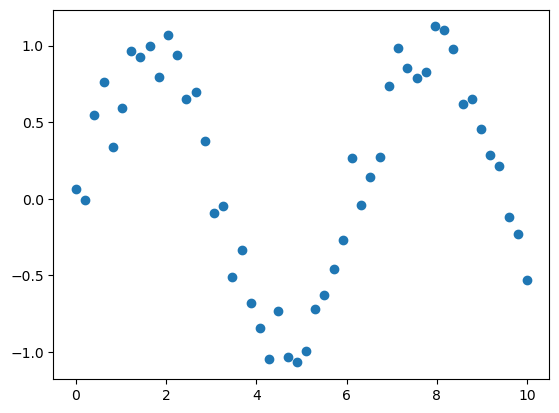

In [10]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
X = np.linspace(0, 10, 50)[:, None]
f_true = np.sin(X).ravel()
y = f_true + rng.normal(scale=0.2, size=len(X))

with pm.Model() as model:
    length_scale = pm.HalfNormal("length_scale", sigma=1.0)
    eta = pm.HalfNormal("eta", sigma=1.0)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)
    gp = pm.gp.Marginal(cov_func=cov)
    sigma = pm.HalfNormal("sigma", sigma=1.0)
    y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=sigma)
    trace = pm.sample()
    post_pred = pm.sample_posterior_predictive(trace)

X_new = np.linspace(-2, 12, 100)[:, None]
with model:
    f_pred = gp.conditional("f_pred", X_new)
    post_pred_gp = pm.sample_posterior_predictive(trace, var_names=["f_pred"])

plt.plot(X, y, "o")
plt.plot(X_new, post_pred_gp["f_pred"].mean(axis=0))
plt.fill_between(
    X_new.ravel(),
    np.percentile(post_pred_gp["f_pred"], 5, axis=0),
    np.percentile(post_pred_gp["f_pred"], 95, axis=0),
    alpha=0.3
)
plt.show()

In [11]:
#Q3

In [23]:
import pymc as pm
import numpy as np
import pytensor.tensor as pt
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
X = rng.normal(0, 1, size=(200, 2))
true_w = np.array([2.0, -1.0])
logits_true = X @ true_w
p_true = 1 / (1 + np.exp(-logits_true))
y = rng.binomial(n=1, p=p_true)

with pm.Model() as nn_model:
    n_hidden = 5
    W1 = pm.Normal("W1", mu=0, sigma=1, shape=(2, n_hidden))
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(n_hidden,))
    hidden = pm.math.tanh(pt.dot(X, W1) + b1)
    W2 = pm.Normal("W2", mu=0, sigma=1, shape=(n_hidden, 1))
    b2 = pm.Normal("b2", mu=0, sigma=1)
    logits = pt.dot(hidden, W2) + b2
    p_out = pm.math.sigmoid(logits).ravel()
    obs = pm.Bernoulli("obs", p_out, observed=y)
    approx = pm.fit(1000, method="advi", progressbar=True)
    trace = approx.sample(1000)

with nn_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["obs"], return_inferencedata=False)

y_pred = np.mean(ppc["obs"], axis=0)
y_pred = np.squeeze(y_pred).round().astype(int)

accuracy = (y_pred == y).mean()
print("Posterior predictive accuracy:", accuracy)



Finished [100%]: Average Loss = 171.57
Sampling: [obs]


Posterior predictive accuracy: 0.50034


The model is applied to a randomly generated 2D dataset with a linear decision boundary.
Using ADVI, the posterior predictive accuracy is approximately 50%, indicating random-like performance.